# Time Series Clustering with K-Means and Euclidean distance for features engineered from individual columns (x, y, z)


----
**Specification of experiment:**
- scripted trips only
- n2 column of acceleration data was used
- Dynamic Time Warping with L1 Norm was calculated

-----
**Results:**

1) KMeans Clustering with 3 Clusters:


    Estimated number of clusters: 3

    True number of clusters: 3*

    Homogeneity: 0.700

    Completeness: 0.510

    V-measure: 0.590

    Adjusted MI: 0.509

    Silhouette Coefficient: 0.854


*Assume that transport modes are true clusters

In [420]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
import tsfresh
import hdbscan

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import plot_3D




%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
#from features.build_features import engineer_features_with_tsfresh
%aimport models.cluster
from models.cluster import get_clustering_performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

Start with scripted trips.

In [4]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
scripted_trips_only = trips_cut_per_30_sec[trips_cut_per_30_sec["scripted"] == 1]
scripted_trips_only = scripted_trips_only.reset_index(drop=True)

print(scripted_trips_only)

    snippet_0 snippet_1 snippet_2 snippet_3 snippet_4 snippet_5 snippet_6  \
0     14.2253   13.5881     10.69   7.73972   4.89432   2.43717   4.87006   
1     12.4412   16.9083   9.27941    16.087   4.83314   14.3418   8.86641   
2     5.94813    10.333   13.3339   5.67077   8.51675   8.52197   8.28837   
3     3.81258   4.64708   6.29619   13.4666   15.4711   9.92297   11.8565   
4     12.5063   10.9826   10.1726   7.40962   4.84207   3.83804    4.4331   
5     14.1234   13.0369   11.3874   14.9609   12.5907    8.1907    6.2167   
6     7.14345    9.0008   7.95653   10.2334   11.7463   12.2507   13.6629   
7     8.28359   12.1244   8.88677   6.91443    8.2433   7.03717   9.06043   
8     13.4902   11.0228   12.2218   13.5984   9.31819   5.90673   2.62495   
9     16.1567   11.5098   12.3914   11.7756   12.0754   6.50454   8.01176   
10    7.75874   5.92339   2.85814   4.37035   7.96436   13.3492   14.5223   
11    8.12795    7.9683   8.91671   10.5352   12.9422   12.0225   11.6223   

Prepare trip dataframe for tsfresh.

In [505]:
# Drop categorical columns.
df = scripted_trips_only
df = df.drop(categorical_columns,axis=1)

# Stack dataframe so that it can be parsed by tsfresh.
df = pd.DataFrame(df.stack(), columns=['value'])

# Copy indices into columns.
df = df.reset_index()

# Rename columns.
df.columns = ['snippet_id', 'snippet_time', 'value']

# Cast values to numeric attributes.
df['value'] = pd.to_numeric(df['value'])

### Choose which features to use

Use `tsfresh` to find relevant features (with default settings).

In [509]:
extraction_settings = tsfresh.feature_extraction.ComprehensiveFCParameters()
settings_minimal = tsfresh.feature_extraction.settings.MinimalFCParameters()

extracted_features = tsfresh.extract_features(
    df, 
    column_id="snippet_id", 
    column_sort="snippet_time",
    column_value="value",
    default_fc_parameters=extraction_settings,
    impute_function=tsfresh.utilities.dataframe_functions.impute,
    n_jobs=4
)


Feature Extraction: 100%|██████████| 20/20 [10:29<00:00, 31.48s/it]


In [514]:
# Run evaluation of features against baseline ground truth of three transport modes.
# Note: n in ground truth has to correlate with number of IDs (in this case: Snippet ID), not with total number of samples (in this case: number of seconds).
features_filtered = tsfresh.select_features(
    extracted_features, 
    scripted_trips_only['mode'],
    ml_task='classification',
    fdr_level=0.01
)

print(features_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 910
Columns: 337 entries, value__variance_larger_than_standard_deviation to value__number_peaks__n_1
dtypes: float64(337)
memory usage: 2.3 MB
None


In [555]:
features_used = pd.DataFrame(scale(features_filtered),columns=features_filtered.columns)
features_used.head(2)

variable,value__variance_larger_than_standard_deviation,"value__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",value__mean_abs_change,value__absolute_sum_of_changes,"value__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","value__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2",value__cid_ce__normalize_False,"value__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","value__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",...,value__index_mass_quantile__q_0.3,"value__fft_coefficient__coeff_60__attr_""imag""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__fft_coefficient__coeff_5__attr_""imag""","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5","value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_5",value__approximate_entropy__m_2__r_0.3,value__approximate_entropy__m_2__r_0.1,value__number_peaks__n_1
0,1.50119,1.35712,1.720980,1.35712,1.35712,0.807619,0.658225,1.246296,0.858579,1.359492,...,-0.406678,-0.937234,0.249672,-0.920706,-0.069361,1.393980,0.679482,0.843401,0.357385,0.769661
1,1.50119,1.47485,1.839178,1.47485,1.47485,0.741975,0.617092,1.380813,1.064819,1.300020,...,0.352510,-0.090384,-0.225040,0.365874,0.405226,-0.305717,-0.012998,0.888180,0.084396,0.843137


### Calculate distance matrix for trip snippets using engineered feature set.

In [556]:
# Calculate euclidean norm on standardized features.
distance_matrix = pd.DataFrame(cdist(features_used, features_used, metric='sqeuclidean'))
# Append metadata to distance matrix (each row corresponds to one trip snippet and its distances to other trip snippets).
distance_matrix['mode'] = scripted_trips_only['mode']
distance_matrix['token'] = scripted_trips_only['token']

------
# Model Building

## Create Model with Clustering by KMeans

Use summaries of each distance

Explained Variance Ratio: [ 0.40534217  0.13566567  0.06197216]


Text(0.5,1,'Explained variance ratio of engineered features with PCA')

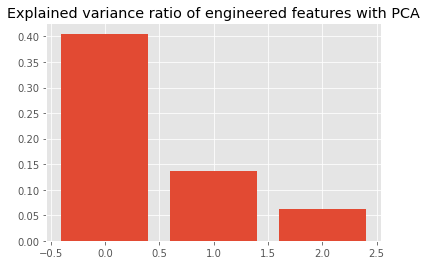

In [557]:
from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components=3)
#reduced = pd.DataFrame(pca.fit_transform(distance_matrix.drop(columns=["mode", "token"])))
reduced = pd.DataFrame(pca.fit_transform(features_used))

features_used = reduced
print("Explained Variance Ratio:",pca.explained_variance_ratio_)

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(np.arange(0, n_components), pca.explained_variance_ratio_)
ax.set_title("Explained variance ratio of engineered features with PCA")

In [558]:
from sklearn.cluster import KMeans
random_state = 0

clusterer = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=50, min_samples=1)
clusterer.fit(features_used)

#kmeans = KMeans(n_clusters=3, random_state=random_state).fit(distance_matrix.drop(columns=["mode", "token"]))
#kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = clusterer.labels_
distance_matrix["cluster_labels"]=cluster_labels

## Plot with PCA

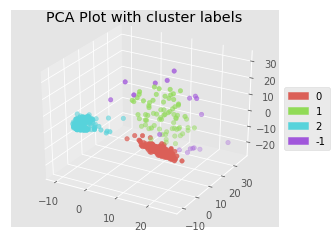

In [559]:
colors,color_patches = get_color_encoding(cluster_labels)
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with cluster labels")


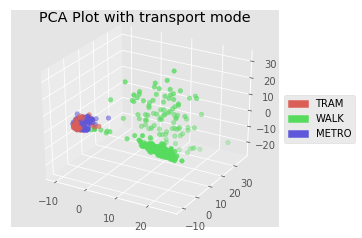

In [560]:
colors,color_patches = get_color_encoding(distance_matrix["mode"])
plot_3D(reduced.iloc[:,0],reduced.iloc[:,1],reduced.iloc[:,2], colors, color_patches,title="PCA Plot with transport mode")


-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [561]:
cluster_performance = get_clustering_performance(features_used,
                                                 cluster_labels,
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 4

 - True number of clusters: 3

 - Homogeneity: 0.664

 - Completeness: 0.517

 - V-measure: 0.581

 - Adjusted MI: 0.515

 - Silhouette Coefficient: 0.784

## Visualise Clustering on 2D - TSNE Plot:

In [413]:
#color_encodings = distance_matrix.loc[:,["cluster_labels","mode", "token"]]
#pure_distance_matrix = distance_matrix.drop(columns=["cluster_labels", "mode", "token"])

#for learning_rate in [50, 100, 1000, 5000, 10000]:
#    for perplexity in [5, 10, 25, 50, 75, 100]:
#        plot_2D_tsne_with_coloring_per_targets(
#            pure_distance_matrix, 
#            color_encodings, 
#            learning_rate=learning_rate,
#            perplexity=perplexity
#        )


## Inspect the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [414]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,229.0,40.0,13.0,WALK
1,0.0,0.0,328.0,TRAM
2,0.0,2.0,299.0,METRO


### Plot distribution of cluster labels for transport modes

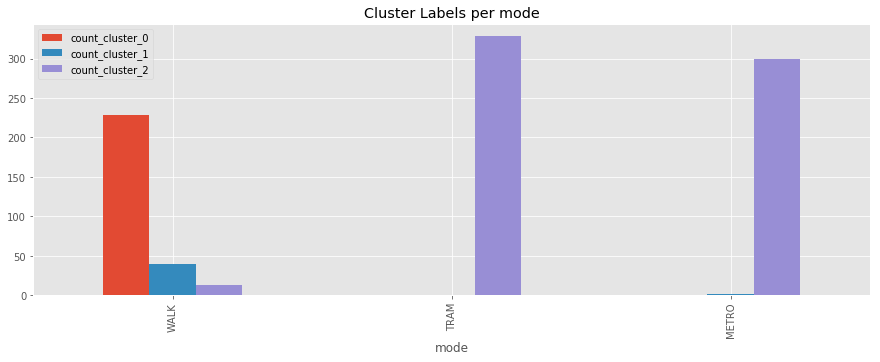

In [415]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for tokens

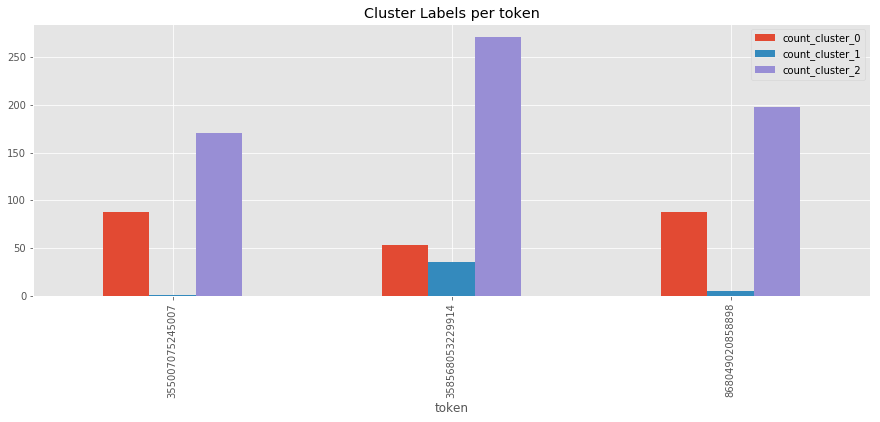

In [416]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

In [417]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)